<a href="https://colab.research.google.com/github/mjain125/Weather_forecasting_using_time_series_analysis/blob/main/Weather_forecasting_using_time_series_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [ ]:
df = pd.read_excel('WRMS_Dataset.xlsx', sheet_name=3)

In [ ]:
city_name = df.columns[1].split("_")[1] +"_"+ df.columns[1].split("_")[2].split(" ")[0]
max_temp= pd.DataFrame()
max_temp['Date'] = pd.to_datetime(df['Date'])
max_temp['GFS_actual']=df['GFS (Actual)MaxTemp']
max_temp['Ground']=df['I_'+city_name+' MaxTemp']
max_temp = max_temp.set_index('Date')
max_temp['topred'] = max_temp['Ground']-max_temp['GFS_actual']

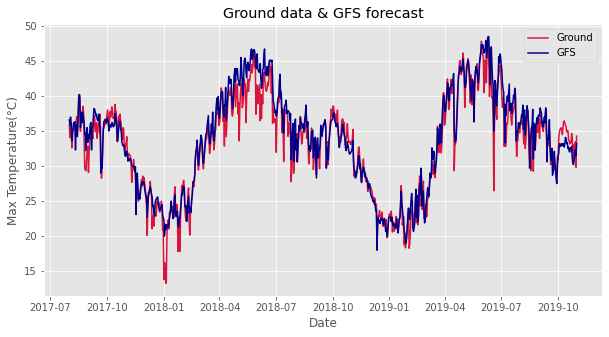

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(max_temp['Ground'], color = 'crimson')
plt.plot(max_temp['GFS_actual'], color = 'darkblue')
plt.xlabel('Date')
plt.ylabel('Max Temperature(°C)')
plt.title('Ground data & GFS forecast')
plt.legend(['Ground', 'GFS'])
plt.savefig('GDGFS')

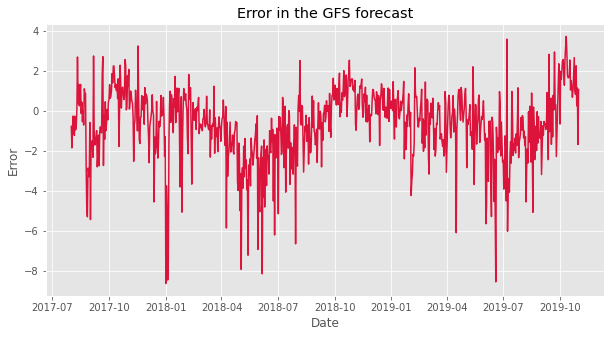

In [ ]:
plt.figure(figsize=(10,5))
plt.xlabel('Date')
plt.ylabel('Error')
plt.title('Error in the GFS forecast')
plt.plot(max_temp['topred'], color = 'crimson')
plt.savefig('GFS_error')

In [ ]:
!pip install pmdarima

In [ ]:
from pmdarima.arima import ndiffs
from pmdarima.arima import ADFTest
ADFTest(alpha = 0.005).should_diff(max_temp['topred'])

(0.01, True)

In [ ]:
max_temp['topred']

Date
2017-08-01   -0.77
2017-08-02   -1.84
2017-08-03   -0.77
2017-08-04   -0.25
2017-08-05   -1.00
              ... 
2019-10-27    2.26
2019-10-28    0.26
2019-10-29    1.15
2019-10-30   -1.67
2019-10-31    1.07
Name: topred, Length: 822, dtype: float64

In [ ]:
a

Date
2017-08-02   -1.07
2017-08-03    1.07
2017-08-04    0.52
2017-08-05   -0.75
2017-08-06   -0.22
              ... 
2019-10-27    1.43
2019-10-28   -2.00
2019-10-29    0.89
2019-10-30   -2.82
2019-10-31    2.74
Name: topred, Length: 821, dtype: float64

In [ ]:
a = max_temp['topred'].diff().dropna()

In [ ]:
ADFTest().should_diff(a)

(0.01, False)

In [ ]:
from statsmodels.tsa.stattools import adfuller
adfuller(a)

(-11.060900957476429,
 4.812470849821376e-20,
 17,
 803,
 {'1%': -3.4385197724757233,
  '10%': -2.5686901720199313,
  '5%': -2.8651460209504114},
 2861.6583773488633)

In [ ]:
adfuller(max_temp['topred'])

(-4.592844157896853,
 0.00013314985216911668,
 8,
 813,
 {'1%': -3.4384189633001956,
  '10%': -2.568666500743605,
  '5%': -2.86510158480911},
 2855.9704576840527)

In [ ]:
from pmdarima.arima import auto_arima
model_autoARIMA = auto_arima(max_temp['topred'].iloc[:-100], start_p=6, d = 1, start_q=4,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=6, qmax_=4, max_d = 5, # maximum p and q
                      m=1,              # frequency of series           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True, random_state = 20, n_fits = 50)
print(model_autoARIMA.summary())

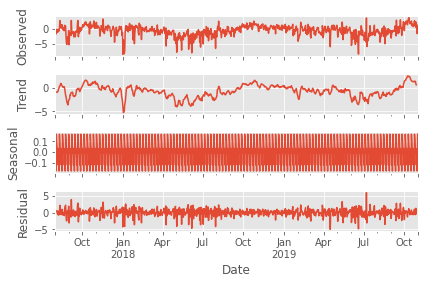

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = max_temp['topred']
result = seasonal_decompose(series, model='additive')
result.plot()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import pacf,acf

dat= pd.DataFrame()
dat['pred'] = max_temp['topred']
val = (np.diff(dat['pred'] ))
dat['pred'] = np.insert(val,-1,0)
lagacf = acf(dat,nlags=365)
lagpacf = pacf(dat,nlags=365,method='ols')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


In [ ]:
dat

,pred
Date,
2017-08-01,-1.07
2017-08-02,1.07
2017-08-03,0.52
2017-08-04,-0.75
2017-08-05,-0.22
...,...
2019-10-27,-2.00
2019-10-28,0.89
2019-10-29,-2.82


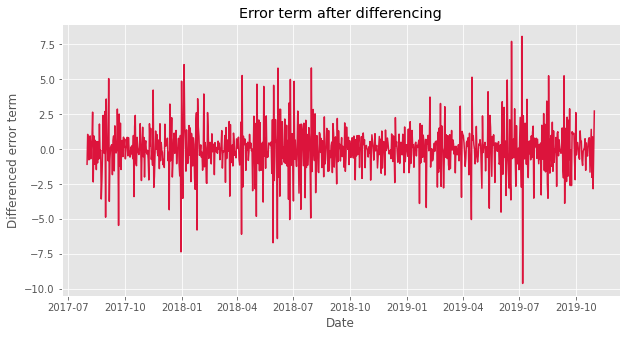

In [ ]:
plt.figure(figsize=(10,5))
plt.xlabel('Date')
plt.ylabel('Differenced error term')
plt.title('Error term after differencing')
plt.plot(dat, color = 'crimson')
plt.savefig('Diif_GFS_error')

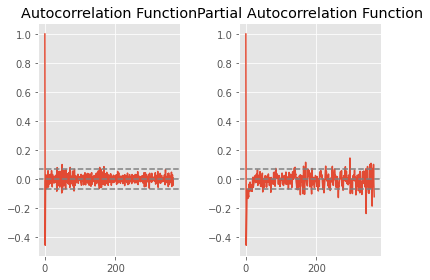

In [ ]:
plt.subplot (121)
plt.plot(lagacf)
plt.axhline (y=0, linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dat)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(dat)),linestyle='--', color='gray')
plt.title('Autocorrelation Function')
 
plt. subplot(122)
plt.plot(lagpacf)
plt.axhline (y=0, linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dat)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(dat)),linestyle='--' , color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.savefig('ACF_PACF')

In [ ]:
dat.head
train=dat.iloc[:-100]
test = dat.iloc[-100:]
dat=train
len(dat)

722

In [ ]:
!pip install pmdarima

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np

model_autoARIMA = auto_arima(train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=6, max_q=6, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      random_state=20, n_fits=50)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2869.032, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2706.433, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2603.928, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2587.141, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2578.699, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2655.357, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2577.369, Time=0.25 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=2640.946, Time=0.07 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=2579.368, Time=0.34 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=2579.368, Time=0.47 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2578.588, Time=0.42 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=2640.523, Time=0.11 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=2580.754, Time=0.50 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=2579.285, Time=0.75 sec

Best model:  ARIMA(3,0,1)(0,0,0)

In [ ]:
dat = train

In [ ]:
from statsmodels.tsa.arima_model import ARIMA 

model =ARIMA(dat, order=(3, 0, 1))
results= model.fit(disp=-1, method = 'mle')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [ ]:
print(results.summary())

                              ARMA Model Results                              
Dep. Variable:                   pred   No. Observations:                  722
Model:                     ARMA(3, 1)   Log Likelihood               -1283.642
Method:                           mle   S.D. of innovations              1.431
Date:                Mon, 30 Nov 2020   AIC                           2579.285
Time:                        14:59:19   BIC                           2606.777
Sample:                    08-01-2017   HQIC                          2589.897
                         - 07-23-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0016      0.006     -0.290      0.772      -0.013       0.009
ar.L1.pred     0.2265      0.041      5.509      0.000       0.146       0.307
ar.L2.pred     0.1269      0.040      3.142      0.0

In [ ]:
if city_name != "Sirsaganj_16041":
    testingidx = 753
else:
    testingidx = 722
predicted = results.predict(testingidx,testingidx+99)
predicted

2019-07-24   -0.922902
2019-07-25   -0.097106
2019-07-26   -0.051755
2019-07-27   -0.091807
2019-07-28   -0.035332
                ...   
2019-10-27   -0.001630
2019-10-28   -0.001630
2019-10-29   -0.001630
2019-10-30   -0.001630
2019-10-31   -0.001630
Freq: D, Length: 100, dtype: float64

In [ ]:
test

,pred
Date,
2019-07-24,1.66
2019-07-25,-3.49
2019-07-26,0.80
2019-07-27,0.16
2019-07-28,0.25
...,...
2019-10-27,-2.00
2019-10-28,0.89
2019-10-29,-2.82


Plotting AR model


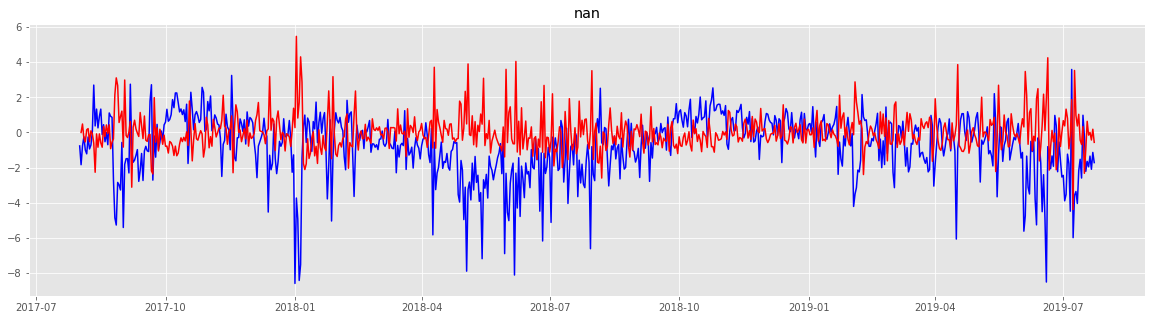

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(max_temp['topred'].iloc[:-100], color = 'blue')
plt.plot(results.fittedvalues, color='red')
print(sum((results.fittedvalues-max_temp['topred'].iloc[:-100])**2)/753)

# plt.tight_layout()
print('Plotting AR model')

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(results.fittedvalues, dat['pred'])


1.000599228085716

In [ ]:
res = results.fittedvalues.append(predicted)
res

2017-08-01   -0.001630
2017-08-02    0.480945
2017-08-03   -0.329975
2017-08-04   -0.537777
2017-08-05    0.154843
                ...   
2019-10-27   -0.001630
2019-10-28   -0.001630
2019-10-29   -0.001630
2019-10-30   -0.001630
2019-10-31   -0.001630
Length: 822, dtype: float64

In [ ]:
data_new = max_temp['topred'] + res


In [ ]:
data_n = data_new.reset_index(drop=True)


In [ ]:
data_n = data_n.iloc[:-1]
data_n.reset_index(drop=True,inplace=True)

In [ ]:
max_t = max_temp.reset_index(drop=True)


In [ ]:
max_t = max_t.iloc[1:]
max_t.reset_index(drop=True,inplace=True)

In [ ]:
new_GFS_actual = max_t['GFS_actual'] + data_n
new_GFS_actual

0      35.128370
1      35.640945
2      35.000025
3      32.812223
4      33.854843
         ...    
816    31.628370
817    34.158370
818    32.558370
819    32.648370
820    31.528370
Length: 821, dtype: float64

In [ ]:
print(mean_absolute_percentage_error(max_t['Ground'][testingidx:],new_GFS_actual[testingidx:]))
print(mean_absolute_error(max_t['Ground'][testingidx:],new_GFS_actual[testingidx:]))
print(rmse(max_t['Ground'][testingidx:],new_GFS_actual[testingidx:]))


3.922885988154302
1.306120668536232
2.8884096940924993


In [ ]:
print(mean_absolute_percentage_error(max_t['Ground'][testingidx:],max_t['GFS_actual'][testingidx:]))
print(mean_absolute_error(max_t['Ground'][testingidx:],max_t['GFS_actual'][testingidx:]))
print(rmse(max_t['Ground'][testingidx:],max_t['GFS_actual'][testingidx:]))
max_t['new_predicted'] = new_GFS_actual

4.328650622010553
1.460606060606061
3.0573777777777784


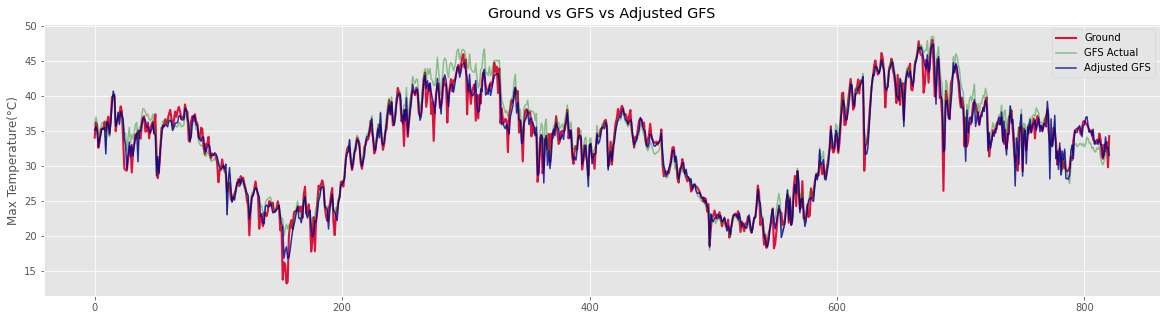

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(max_t['Ground'],label='Ground', color = 'crimson', linewidth=2.1)
plt.plot(max_t['GFS_actual'],label='GFS Actual',color='green', alpha=0.4)
plt.plot(max_t['new_predicted'],label='Adjusted GFS',color="darkblue",alpha=0.8)
plt.ylabel('Max Temperature(°C)')
plt.title('Ground vs GFS vs Adjusted GFS')
plt.legend()
plt.savefig('last_plot')

In [ ]:
train = dat.iloc[:-100]
test = dat.iloc[-100:]

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train, order=(6, 0, 4))
results= model.fit(disp=-1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
train.size

752

In [ ]:
testingidx = 752
predicted = results.predict(testingidx,testingidx+99)
predicted

2019-07-24    1.913422
2019-07-25    0.043329
2019-07-26    0.501141
2019-07-27    0.488565
2019-07-28   -0.024985
                ...   
2019-10-27   -0.034597
2019-10-28    0.043408
2019-10-29    0.036059
2019-10-30   -0.040066
2019-10-31   -0.024620
Freq: D, Length: 100, dtype: float64

In [ ]:
test

Date
2019-07-24    1.12
2019-07-25   -3.74
2019-07-26    2.15
2019-07-27    8.13
2019-07-28   -2.85
              ... 
2019-10-27   -0.85
2019-10-28    0.50
2019-10-29   -0.69
2019-10-30   -0.02
2019-10-31    0.29
Name: topred, Length: 100, dtype: float64

Plotting AR model


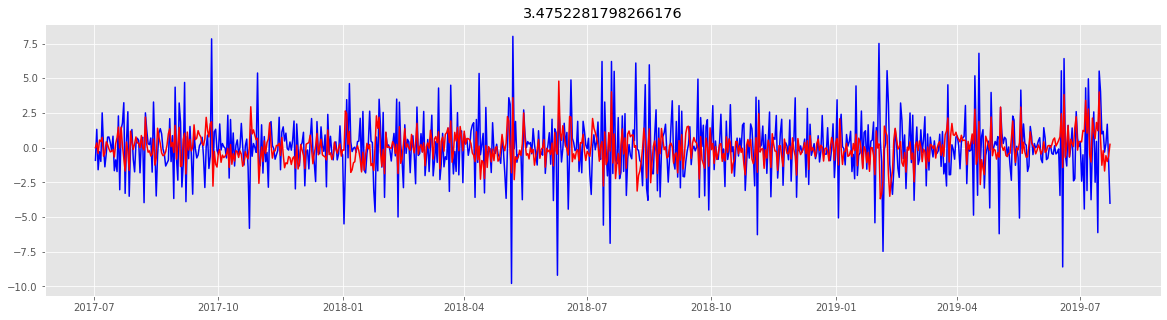

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(train, color = 'blue')
plt.plot(results.fittedvalues, color='red')
plt.title(sum((results.fittedvalues-train)**2)/train.size)

# plt.tight_layout()
print('Plotting AR model')


In [ ]:
res = results.fittedvalues.append(predicted)

In [ ]:
new_GFS_actual = max_temp['GFS_actual'].iloc[1:] + res

In [ ]:
new_GFS_actual

Date
2017-07-02    39.703113
2017-07-03    38.941078
2017-07-04    41.087693
2017-07-05    41.650645
2017-07-06    42.939899
                ...    
2019-10-27    33.965403
2019-10-28    33.843408
2019-10-29    34.336059
2019-10-30    34.959934
2019-10-31    34.475380
Length: 852, dtype: float64

In [ ]:
max_temp['Ground']

Date
2017-07-01    34.83
2017-07-02    35.02
2017-07-03    35.24
2017-07-04    36.55
2017-07-05    35.86
              ...  
2019-10-27    30.18
2019-10-28    30.48
2019-10-29    30.29
2019-10-30    30.97
2019-10-31    30.76
Name: Ground, Length: 853, dtype: float64

In [ ]:
print(mean_absolute_percentage_error(max_temp['Ground'].iloc[1:][testingidx:],new_GFS_actual[testingidx:]))
print(mean_absolute_error(max_temp['Ground'].iloc[1:][testingidx:],new_GFS_actual[testingidx:]))
print(rmse(max_temp['Ground'].iloc[1:][testingidx:],new_GFS_actual[testingidx:]))

4.373658402603294
1.4759990932440439
3.13238924589938


In [ ]:
print(mean_absolute_percentage_error(max_temp['Ground'].iloc[1:][testingidx:],max_temp['GFS_actual'].iloc[1:][testingidx:]))
print(mean_absolute_error(max_temp['Ground'].iloc[1:][testingidx:],max_temp['GFS_actual'].iloc[1:][testingidx:]))
print(rmse(max_temp['Ground'].iloc[1:][testingidx:],max_temp['GFS_actual'].iloc[1:][testingidx:]))


4.328650622010553
1.460606060606061
3.0573777777777784


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
from sklearn.metrics import mean_squared_error as rmse
